In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
from scipy.fftpack import dct
from scipy.cluster.hierarchy import fclusterdata
pd.options.display.max_rows, pd.options.display.min_rows = 1000, 10

In [2]:
df = pd.read_csv('Welding.csv')            # shape = (141800,7)
del df['[Autoindex]'], df['[Machine]']     # Autoindex: 1101~142900 # Machine: MC1A

df = df[100:]                               # drop first half weld due to time interval
df['MCID'] = df['[MCID]'].map(lambda x: 0 if x=='W02' else 1) # MCID=='W02':70900, MCID=='W03':70900
del df['[MCID]']

df = df[df['[WeldTime]']>17]               # less than 5 data: 2~4 # others more than 17. # minus 19
df['WeldTime'] = df['[WeldTime]'].map(lambda x: x-19)
del df['[WeldTime]']

df = df.drop_duplicates(subset='[CreatTime]', ignore_index=True)    # drop duplicates
min_timestamp = dt.timestamp(dt.strptime(df['[CreatTime]'][0],"%Y-%m-%d %H:%M:%S.%f"))
df['CreateTime'] = df['[CreatTime]'].map(lambda x: \
    dt.timestamp(dt.strptime(x,"%Y-%m-%d %H:%M:%S.%f")) - min_timestamp )
del df['[CreatTime]']                      # change str to timestamp and shift to initial

vmean, vstd = df['[EleVoltage]'].mean(), df['[EleVoltage]'].std()
cmean, cstd = df['[EleCurrent]'].mean(), df['[EleCurrent]'].std()
print('vmean=%f, vstd=%f, cmean=%f, cstd=%f'%(vmean, vstd, cmean, cstd))
df['Voltage'] = (df['[EleVoltage]']-vmean)/vstd
df['Current'] = (df['[EleCurrent]']-cmean)/cstd
del df['[EleVoltage]'], df['[EleCurrent]'] # standarization of current and voltage

df

vmean=2626.771708, vstd=37.381913, cmean=3018.201925, cstd=80.217606


,MCID,WeldTime,CreateTime,Voltage,Current
0,1,0.37,0.000,-0.261402,0.047347
1,1,0.40,0.003,0.862136,-0.925008
2,1,0.40,0.007,1.236649,-0.850211
3,1,0.40,0.010,2.413688,-1.922295
4,1,0.40,0.013,0.166612,0.009949
...,...,...,...,...,...
27946,1,0.40,231093.217,1.691414,-1.024737
27947,1,0.40,231093.220,2.413688,-2.346142
27948,1,0.46,231093.223,2.413688,-2.184083
27949,1,0.43,231093.227,1.798418,-1.461050


In [3]:
weldingList = []
first_weld_start, i = 0, 1
while i<len(df):                 # divide df into tuples:(W02,W03)
    while i<len(df) and df['MCID'][i]==1:
        i+=1
    first_weld_end = i
    while i<len(df) and df['MCID'][i]==0:
        i+=1
    fdf, sdf = df.iloc[first_weld_start:first_weld_end,:], df.iloc[first_weld_end:i,:]
    if fdf['CreateTime'].std()<3 and sdf['CreateTime'].std()<3:  # filter each df has large std
        weldingList.append((fdf, sdf))
    first_weld_start = i

print('Welding times = %d'%len(weldingList))
df_lens = np.array(list(map(lambda x:np.array([len(x[0]),len(x[1]),len(x[0])+len(x[1])]),weldingList)))
print('first_times_mean=%d'%df_lens[:,0].mean(), ' first_times_std=%d'%df_lens[:,0].std())
print('second_times_mean=%d'%df_lens[:,1].mean(), 'second_times_std=%d'%df_lens[:,1].std())
print('total_times_mean=%d'%df_lens[:,2].mean(), ' total_times_std=%d'%df_lens[:,2].std())
print('tot_data=%d'%int(len(weldingList)*df_lens[:,2].mean()))
for i in range(len(weldingList)):
    print('-'*30 + str(i) + '-'*30)
    print(weldingList[i][0])
    print(weldingList[i][1])
    break

Welding times = 696
first_times_mean=19  first_times_std=2
second_times_mean=19 second_times_std=3
total_times_mean=39  total_times_std=3
tot_data=27440
------------------------------0------------------------------
    MCID  WeldTime  CreateTime   Voltage   Current
79     1      0.40     176.847  0.701631 -0.351568
80     1      0.37     176.850  1.958923 -0.987338
81     1      0.40     176.853  2.012425 -1.760236
82     1      0.40     176.857  0.862136 -0.825279
83     1      0.40     176.860  1.530909 -0.837745
84     1      0.40     176.863  1.049392 -0.513627
85     1      0.40     176.867  0.246865  0.346533
86     1      0.37     176.870  0.139862  0.159542
87     1      0.40     176.873 -0.395157  0.221872
88     1      0.43     176.877  0.246865 -0.089780
89     1      0.40     176.880 -0.074146  0.408864
90     1      0.40     176.883  0.701631  2.328642
91     1      0.40     176.887  0.166612 -0.039915
92     1      0.43     176.890  0.139862  2.478235
93     1      0.40  

In [4]:
def dtw(a,b):
    a, b = a[a!=0], b[b!=0]
    D = np.zeros((len(a), len(b)))
    D[0][0] = abs(a[0]-b[0])
    for i in range(1,len(b)):
        D[0][i] = abs(a[0]-b[i]) + D[0][i-1]
    for j in range(1,len(a)):
        D[j][0] = abs(a[j]-b[0]) + D[j-1][0]
    for i in range(1,len(a)):
        for j in range(1,len(b)):
            D[i][j] = abs(a[i]-b[j]) + min(D[i-1][j-1], D[i-1][j], D[i][j-1])
    return D[-1][-1]

In [5]:
L = []
for fdf, _ in weldingList:
    A = dct( fdf['Voltage'].to_numpy() )
    L.append( np.concatenate((A,np.zeros(50-len(A)))) )
L = np.array(L[:100])

In [6]:
from sklearn.manifold import TSNE
R = TSNE(n_components=2).fit_transform(L)

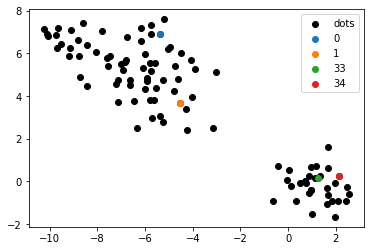

In [7]:
plt.scatter(R[:,0],R[:,1], c='black')
plt.scatter(R[0,0],R[0,1])
plt.scatter(R[1,0],R[1,1])
plt.scatter(R[33,0],R[33,1])
plt.scatter(R[34,0],R[34,1])
plt.legend(labels=['dots', '0', '1', '33', '34'])
plt.show()

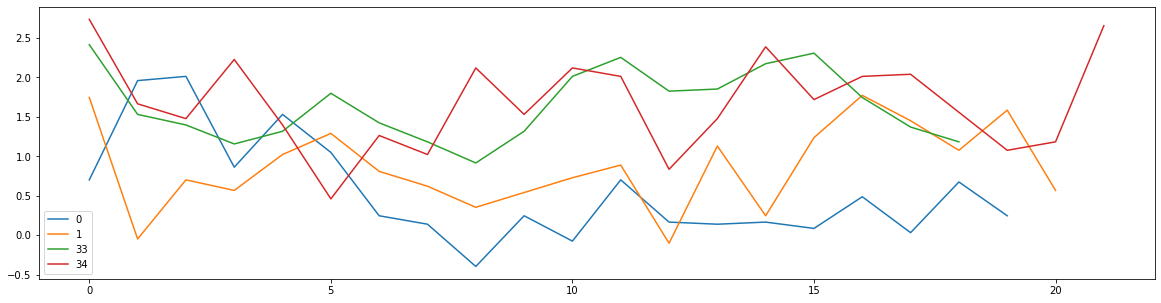

In [8]:
plt.figure(figsize=(20,5))
plt.plot( weldingList[0][0]['Voltage'].to_numpy() )
plt.plot( weldingList[1][0]['Voltage'].to_numpy() )
plt.plot( weldingList[33][0]['Voltage'].to_numpy() )
plt.plot( weldingList[34][0]['Voltage'].to_numpy() )
plt.legend(labels=['0','1','33','34'])
plt.show()

In [80]:
labels = fclusterdata(L, t=1.5, metric=dtw)
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [9]:
L = []
for i in range(len(weldingList)-1):
    for j in range(i+1,len(weldingList)):
        L.append((i,j,dtw(list(weldingList[i][0]['Voltage']), list(weldingList[j][0]['Voltage']))) )
        #break
    break
L

TypeError: object of type 'float' has no len()

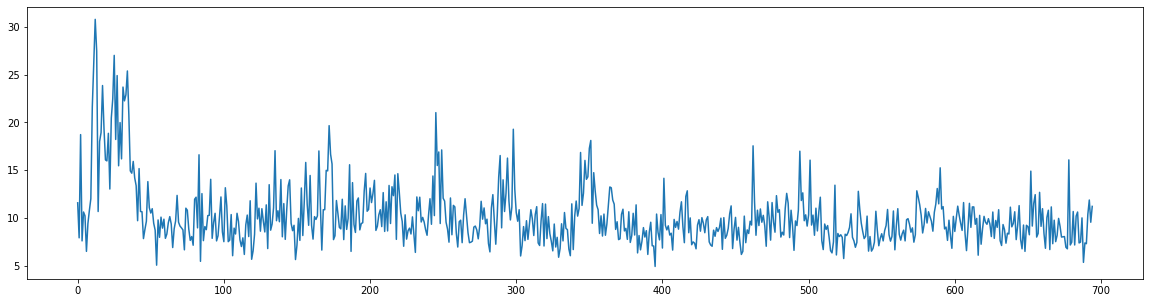

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot([d[2] for d in L])
plt.show()

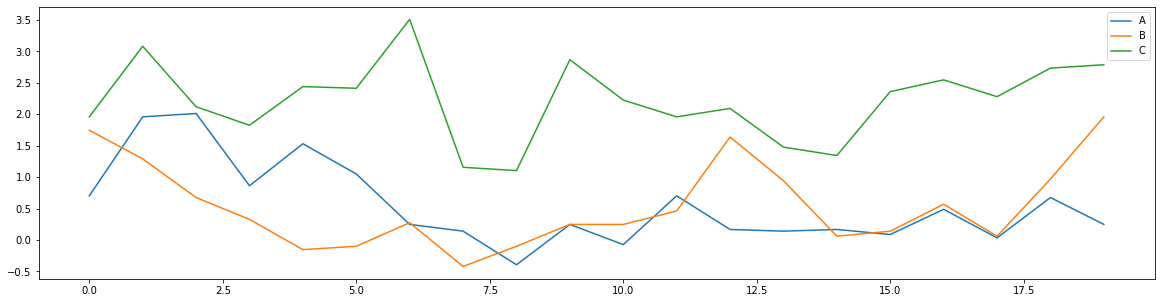

In [14]:
A = list(weldingList[0][0]['Voltage'])
B = list(weldingList[78][0]['Voltage'])
C = list(weldingList[13][0]['Voltage'])
plt.figure(figsize=(20,5))
plt.plot(A)
plt.plot(B)
plt.plot(C)
plt.legend(labels=['A','B','C'])
plt.show()